In [4]:
#%pylab inline
#from ipywidgets import interact
import scipy.stats
from skimage import img_as_float, img_as_ubyte
from matplotlib.image import imread
import glob,os
from numpy import genfromtxt
import pandas as pd
from pandas import DataFrame as df
#import numpy as np
#import matplotlib

In [2]:
import dibpy

References and useful links:
- [PDF of book exploring P, Solubility etc.](http://www.pharmaresearchlibrary.com/wp-content/uploads/2013/03/absorption_and_drug_development_-_solubility_permeability_and_charge_state.pdf) - Page 160
- [Yohan Lee paper exploring SLB, UV detection platform](https://pubs.acs.org/doi/pdf/10.1021/acs.analchem.7b03004)
- [Notes on error propagation](http://lectureonline.cl.msu.edu/~mmp/labs/error/e2.htm)
- [Markdown - mathematical formula](http://csrgxtu.github.io/2015/03/20/Writing-Mathematic-Fomulars-in-Markdown/)

### Permeability equation

Mass balance:

$$ {C_D(0) V_D(t)} + {C_A(0) V_A(t)} = {C_A(t) V_A(t)}+{C_D(t) V_D(t)}$$

If we assume that VD and VA are equal:

$$ C_D(0) + C_A(0) = C_A(t)+C_D(t)$$

This defines the equilbrium concentration as:

$$ C_{EQ} = \frac {C_D(0) + C_A(0)}{2}$$

Or:

$$ 2 C_{EQ} = C_D(t) + C_A(t)$$

Fitting this back into Ficks first law:

$$ \frac {\partial{C_A (t)}}{\partial{t}} = \frac {A}{V_A} 2 P (C_{EQ} - C_A(t)) $$
 
In terms of P:

$$ P = \frac {V_A} {2 A (C_{EQ} - C_A(t))} \frac {\partial{C_A (t)}}{\partial{t}} $$

 First we need to approximate the bilayer area. In the case of a DIB we can use A = πR<sup>2</sup> and make the assumption that the bilayer is a flat circle. Therefore we can just use the radius of the interface as measured by microscopy. The bilayer area was determined via microscopy previously via an n=4 dataset.

In [6]:
# this still needs work

DIB17radius = 0.81 / 2    #three different radii are determined based on image analysis.
DIB3radius = 0.82/2
DIBX_2radius = 0.74/2


DIB17area = dibpy.circlearea(DIB17radius/10)  # convert to cm from mm and conduct area calculation using pi*r^2
DIB3area = dibpy.circlearea(DIB3radius/10) 
DIBX_2area = dibpy.circlearea(DIBX_2radius/10)


DIBavr = (DIB17radius,DIB3radius, DIBX_2radius) # store the radii into a single variable
DIBavA = (DIB17area, DIB3area, DIBX_2area)

DIBavmean = np.mean(DIBavA) # two different ways of detemring area
average_DIBarea = ((DIB17area + DIB3area + DIBX_2area) / 3)  # this variable will be used downstream

average_DIBareasd = std(DIBavA, ddof=1)
no_elements = len(DIBavA)
average_DIBarease = average_DIBareasd/(no_elements**0.5)

In [7]:
print('As determined via microscopy the average DIB area within the RheoDIB is:' , average_DIBarea )
print('As determined via microscopy the standard error in DIB area within the RheoDIB is:' , average_DIBarease)

As determined via microscopy the average DIB area within the RheoDIB is: 0.0049116183144998415
As determined via microscopy the standard error in DIB area within the RheoDIB is: 0.00030761695434825643


# Calibration

In considering the calibration method, it is worth taking into account the effect of [Heteroscedasticity](https://en.wikipedia.org/wiki/Heteroscedasticity). This effect describes how sub populations of a data series may exert local variability outside of the general trend. In the case of the RheoDIB, quantifying higher concentrations becomes unclear.

The calibration data will have to be added into a single directory and then this directory will be analysed.

### Perform calibration

To make this work - we may need to specify a specific way of saving the files within the directory.

In [9]:
rootdir = r'C:/Users/fts18/OneDrive - Imperial College London/MRes/Permeability Assays/Paracetamol_DOPC/4_4_19/Calibrations'
# simplified all this, now we just call from the dibpy module
all_calibdata = dibpy.performCalibration(rootdir)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:/Users/fts18/OneDrive - Imperial College London/MRes/Permeability Assays/Paracetamol_DOPC/4_4_19/Calibrations'

In [ ]:
# user input calibration list:
cal_list = ['250_1', '250_2', '250_3', '375_1', '375_2', '375_3', '500_1', '500_2', '500_3']
cal_points_list = ['250', '375', '500']
# dicionary of data is created
cal_dict = {cl : all_calibdata['Average of run'][all_calibdata['File name']==cl].values for cl in cal_list}
    

In [36]:
# dummy cal_dict 
cal_dict = {'250_1': 1, '250_2' : 3, '250_3' : 5, '375_1': 100, '375_2':200, '375_3':300, '500_1':1000, '500_2':2000, '500_3':3000}

# you can do something like this, we can optmize this later...
raws = []
for cpl in cal_points_list:
    temp_points_list = []
    for cd in cal_dict:
        if cd[0:3] == cpl:
            temp_points_list.append(cal_dict[cd])
    print(np.mean(temp_points_list), np.std(temp_points_list))
    raws.append([np.mean(temp_points_list),np.std(temp_points_list)])
            
raws = np.array(raws)

3.0 1.632993161855452
200.0 81.64965809277261
2000.0 816.496580927726


In [40]:

#concs = np.array([250, 375, 500])
concs = np.array([ int(cpl) for cpl in cal_points_list])

#raws = np.array([vals250_mean, vals375_mean, vals500_mean])
# raws now keeps the data and error together to avoid making a mistake

3.70196992604388 0.9073013409860691 7.988 -2261.1666666666665


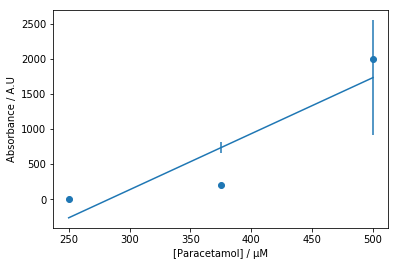

In [41]:

calibslope, calibintercept, calibr_value, calibp_value, calib_err = scipy.stats.linregress(concs, raws[:,0])

plt.scatter(concs,  raws[:,0])
plt.ylabel('Absorbance / A.U')
plt.xlabel('[Paracetamol] / \u03BCM')
#plt.plot(concs, calibslope*concs + calibintercept, linestyle='--')
plt.errorbar(concs, calibslope*concs + calibintercept, yerr=raws[:,1])
print(calib_err, calibr_value, calibslope, calibintercept)

### Create dataframe with all the permeability run data

500D_250A_2


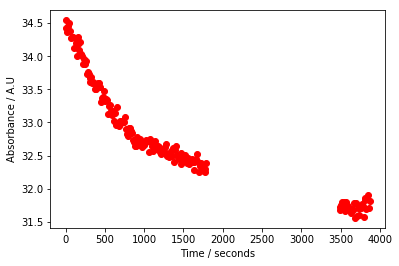

500D_250A_3


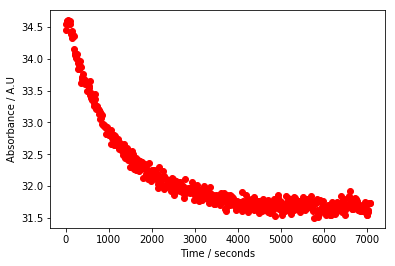

,Absorbance,Average of run,Average of run error,File name,Timestamps
0,"[34.54316543903971, 34.42394499498558, 34.3717...",32.786162,0.004053,500D_250A_2,"[0, 10, 22, 34, 46, 56, 68, 80, 92, 104, 116, ..."
1,"[34.55216322464116, 34.454695422531806, 34.591...",32.144721,0.001175,500D_250A_3,"[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 118, ..."


In [93]:
# this is the sampe procedure as before, so we want to reuse the code not make a copy. We can change the function name if needed
rootdir = r'C:/Users/fts18/OneDrive - Imperial College London/MRes/Permeability Assays/Paracetamol_DOPC/4_4_19/Permnospin'  #rootdirectory goes here - use forward slashes
all_data = dibpy.performCalibration(rootdir)

,Concentration,File name,Normalised concentration,Timestamps
0,"[203.2481849168375, 204.71521340984734, 206.62...",1,"[0.7390843087885, 0.7444189578539904, 0.751348...","[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66,..."
1,"[266.0549156170926, 260.87952034711583, 268.05...",500D_250A_1,"[0.9674724204257913, 0.9486528012622394, 0.974...","[0, 12, 22, 34, 46, 56, 68, 80, 92, 102, 114, ..."
2,"[239.59642989505454, 243.79852546838777, 245.6...",500D_250A_2,"[0.8712597450729256, 0.8865400926123191, 0.893...","[0, 10, 22, 34, 46, 56, 68, 80, 92, 104, 116, ..."
3,"[239.59642989505454, 243.79852546838777, 245.6...",500D_250A_2,"[0.8712597450729256, 0.8865400926123191, 0.893...","[0, 10, 22, 34, 46, 56, 68, 80, 92, 104, 116, ..."


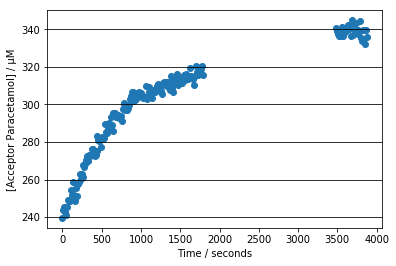

In [94]:
source = 500 #um
sink = 50 #uM
# we already have...
calibslope, calibintercept, calibr_value, calibp_value, calib_err

# now call the function apply calibration:
all_solveddata = dibpy.applyCalibration(source, sink, all_data, raw_intensity, calibintercept, calibslope)


In [96]:
linearP, pm, pc, filtered_pconc, filtered_ptime = dibpy.filterdatframe(dataframe, count, upper, lower)

This function spits out an array which contains the following items (indexed):
- 0 = linearP - The covariance matrix from the linear fit
- 1 = pm - The gradient of the linear fit
- 2 = pc - The intercept of the linear fit
- 3 = filtered_pconc - The concentration filtered based on an upper and lower limit (i.e. from 0.5 - 1mM).
- 4 = filtered_ptime - The associated timestamps

Before completing the automation of determination of P, we can bolt on the consideration of error propagation. The source of error is determined by: 
- Error in calibration method - this is the same standard error as on the linear fit curve.
- Pippetting error (confidence in volume determination) - source from literature
- Error on linear region from which to extract the differential component from (above code)
- Error on bilayer area - Determined via n=X repeats of microscope studies
- Biological repeat error at P determination level 

In the RheoDIB equation the, Propagation_of_P_error function defines the error on P as derived:

Let: 

$$ m = \frac {\partial{C_A (t)}}{\partial{t}}$$

Recalling the equation:

$$ P = \frac {m V_A} {2 A (C_{EQ} - C_A(t))} $$

Taking the partial derivative of each component yields:

$$ \frac{{\partial{P}}}{{\partial{V_A}}} = \frac {m}{2 A (C_{EQ} - C_A(t))} $$

$$ \frac{{\partial{P}}}{{\partial{A}}} = \frac {m V_A}{2 A^2 (C_{EQ} - C_A(t))} $$

$$ \frac{{\partial{P}}}{{\partial{C_A}}} = \frac {m V_A}{2 A (C_{EQ} - C_A(t))^2} $$

$$ \frac{{\partial{P}}}{{\partial{m}}} = \frac {V_A}{2 A (C_{EQ} - C_A(t))} $$


Recalling the definition of error in a general function: 

$$ {\partial{R}} = \sqrt{(\frac{{\partial{X}}}{X}\partial{X})^2 + (\frac{{\partial{Y}}}{Y}\partial{Y})^2 + ...} $$

Inputing the above partial derivatives:

$$ {\partial{P}} = P \sqrt{(\frac{{\partial{V_A}}}{V_A})^2 + (\frac{{\partial{A}}}{A})^2 + {(\frac{{{\partial{m}}}}{{m}})^2 + (\frac{{\partial{CA(t)}}}{C_EQ - CA(t)})^2})}$$

### Perform permeability calculations

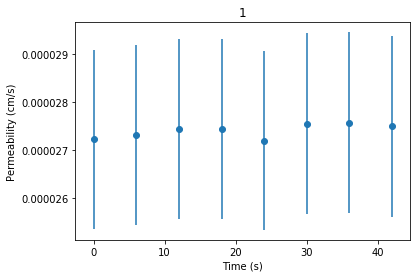

The values for permeability are: [array([2.72193498e-05, 2.73143605e-05, 2.74387723e-05, 2.74368747e-05,
       2.71940069e-05, 2.75456881e-05, 2.75674808e-05, 2.74894494e-05])]
The error for each permeability is: [array([1.86947296e-06, 1.87599846e-06, 1.88454328e-06, 1.88441295e-06,
       1.86773236e-06, 1.89188645e-06, 1.89338321e-06, 1.88802387e-06])]
The R2 value for the linear fit between the upper and lower concentration bounds is: 0.9817072481936676
The SE value for the linear fit between the upper and lower concentration bounds is: 0.0018605613325132929


,File name,Permeability,Permeability propagated error,Standard error of P,Standard error of propagated error
0,1,0.000027,0.000002,1.426967e-07,9.800658e-09


In [98]:
volume = 0.0007                    # input the volume of the acceptor compartment
volume_se = 0.000018               # based on raNdom error - Eppendorf Research® plus – Technical Specifications
average_DIBarea                    # calculated above, variable carries through
average_DIBarease                  # calculated above, variable carries through
donor_0conc = 5                    # input the intiial concentration of the donor compartment
Eq = 625                        # input the equilibrium concentration
conc_error = calib_err          # this is determined via the error on the linear fit in the calibration curve - for now the value comes from excel


all_data = performPermCalc(volume, volume_se, average_DIBarea, average_DIBarease, donor_0conc, Eq, conc_error)

Per run, the error on m will vary. For each molecule / run of the molecule the variance on CA(t) will change, as this element accounts for the calibration. 

Across these timestamps, the average permeability was then taken and the average propagated standard error, with the se on both the average permeability and the propagted permeability error were totalled. Then for each run (n=3) this was averaged (with the same process for the totalled error). The below values condense the entire timstamp plot into single variables, which accounts for the variance in P with time. 

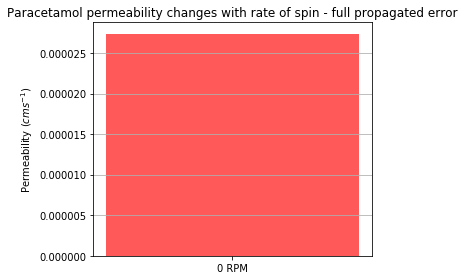

The P value at 0 rpm is: 0.27400747812226256 +/- nan x10^-4cms-1 


In [99]:
# slicing out specific integers from dataframe
p = (all_data['Permeability'])
err = (all_data['Permeability propagated error'])
err_on_P = (all_data['Standard error of P'])
err_on_properr = (all_data['Standard error of propagated error'])

#summing the error columns
errincluded = all_data.assign(my_sum=all_data[['Permeability propagated error', 'Standard error of P', 'Standard error of propagated error']].sum(1))
total_err = (errincluded['my_sum'])    
#averaging the runs (n=3) and calculating total error
mean_p = np.mean(p[0:3]) 
#rpm58av = np.mean(p[3:6])
#rpm0av = np.mean(p[6:8])
mean_err_p = ((np.std(p[0:3], ddof=1))/3) + np.mean(total_err[0:3]) + ((np.std(total_err[0:3], ddof=1))/3) 
#erroron58 = ((np.std(p[3:6], ddof=1))/3) + np.mean(total_err[3:6]) + ((np.std(total_err[3:6], ddof=1))/3)
#erroron0 = ((np.std(p[6:8], ddof=1))/3)  + np.mean(total_err[6:8]) + ((np.std(total_err[6:8], ddof=1))/3)

#variables containing neccesary data
#erroronPs = [erroron0,erroron29,erroron58]
#avPs = [rpm0av,rpm29av, rpm58av]
spins = ['0 RPM']

#plotting 
fig, ax = plt.subplots()
ax.bar(spins, mean_p, yerr=mean_err_p, align='center', alpha=0.65, ecolor='black', capsize=10, color = 'red')
ax.set_ylabel('Permeability ($cm s^{-1}$)')
ax.set_title('Paracetamol permeability changes with rate of spin - full propagated error')
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

#for z,x,y in zip(spins, avPs, erroronPs):
    #print('The P value at', z, 'is:', x*10000, '+/-', y*10000, 'x10^-4cms-1 ')
    
print('The P value at 0 rpm is:', mean_p*10000, '+/-', mean_err_p*10000, 'x10^-4cms-1 ')

Next things to check out, as reccomended by Nate:

- Work in the calibration part now...
- Classes
- SciKitLearn
- PEP8 Guidelines 
- Dictionaries
- Look at other ways of detemrinign P from the PDF linked at top